In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
#from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

In [10]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

In [14]:
common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

Data Loss: 1.0


## Simulation using Student T

In [15]:
params_smi = t.fit(returns['SMI'])
params_stoxx50 = t.fit(returns['STOXX50'])
params_sp500 = t.fit(returns['SP500'])

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

In [16]:
n_simulations = 1
n_timesteps = 30

z = np.random.normal(size=(n_timesteps, n_simulations, 3))
correlated_z = np.matmul(z, chol_matrix.T)
u = norm.cdf(correlated_z)

sim_smi = t.ppf(u[:, :, 0], *params_smi)
sim_stoxx50 = t.ppf(u[:, :, 1], *params_stoxx50)
sim_sp500 = t.ppf(u[:, :, 2], *params_sp500)

initial_prices = {
    'SMI': smi['Price'].iloc[-1],
    'STOXX50': stoxx50['Price'].iloc[-1],
    'SP500': sp500['Price'].iloc[-1]
}

price_paths_smi = initial_prices['SMI'] * np.exp(np.cumsum(sim_smi, axis=0))
price_paths_stoxx50 = initial_prices['STOXX50'] * np.exp(np.cumsum(sim_stoxx50, axis=0))
price_paths_sp500 = initial_prices['SP500'] * np.exp(np.cumsum(sim_sp500, axis=0))

price_paths = {
    'SMI': price_paths_smi,
    'STOXX50': price_paths_stoxx50,
    'SP500': price_paths_sp500
}

In [17]:
corr_matrix

,SMI,STOXX50,SP500
SMI,1.000000,0.792539,0.501169
STOXX50,0.792539,1.000000,0.592526
SP500,0.501169,0.592526,1.000000


## Simulation using GBM with the CIR model

Using an MLE to estimate paramters for the CIR model

In [44]:
from scipy.optimize import minimize

# Load data
interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
r = interest_rates["United States Treasury 10-YR Rates"].dropna().values

dt = 1 / 252  # Time step

# Define negative log-likelihood function
def negative_log_likelihood(params, r, dt):
    kappa, theta, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    for t in range(len(r) - 1):
        dr = r[t + 1] - r[t]
        mean_increment = kappa * (theta - r[t]) * dt
        variance_increment = sigma_r**2 * r[t] * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds
initial_vals = [0.1, np.mean(r), np.std(r)]
bounds = ((1e-5, None), (None, None), (1e-5, None))

# Optimization
result = minimize(
    negative_log_likelihood, initial_vals, args=(r, dt), bounds=bounds, method="L-BFGS-B"
)

kappa, theta, sigma_r = result.x
print("Fitted Parameters:")
print("kappa:", kappa)
print("theta:", theta)
print("sigma_r:", sigma_r)

Fitted Parameters:
kappa: 0.12479397159019213
theta: 6.461329307892663
sigma_r: 0.6839524029950487


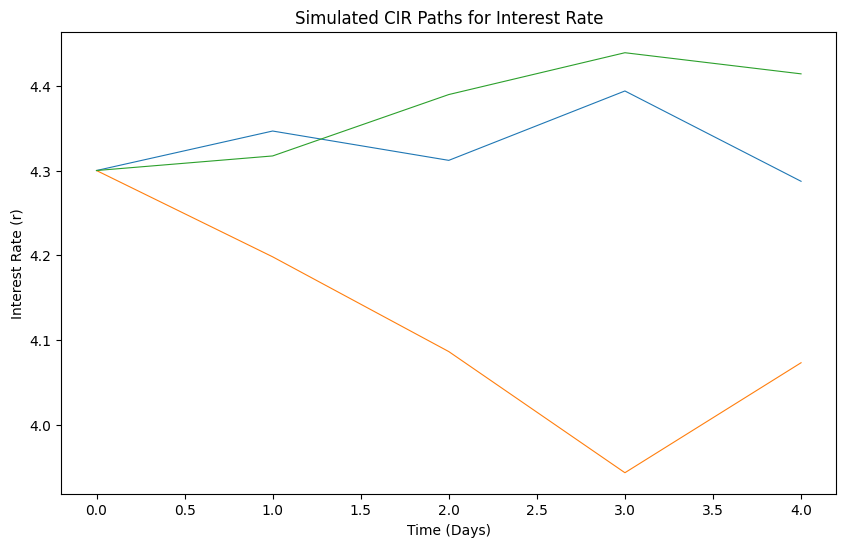

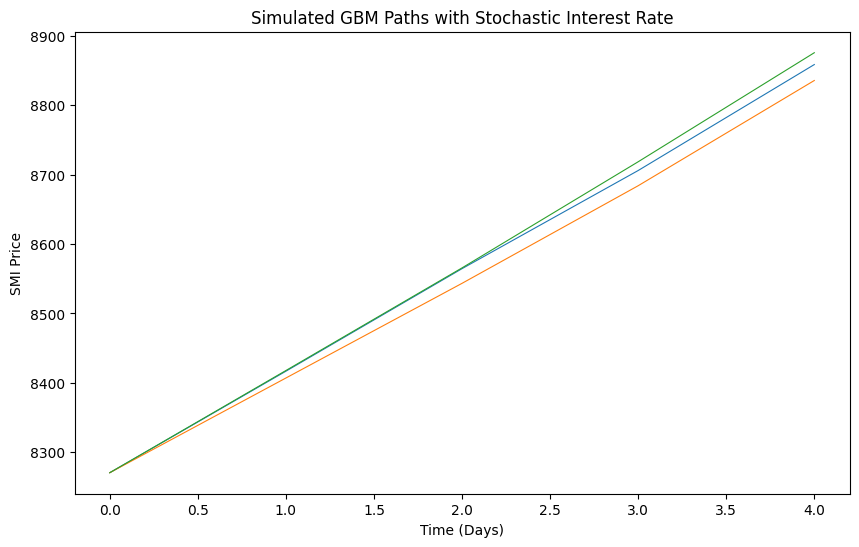

In [ ]:
n_simulations = 3
n_timesteps = 4

mu = {}
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    mean_return = returns[index].mean()
    variance = returns[index].var()
    mu[index] = mean_return
    sigma[index] = np.sqrt(variance)

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
Z_flat = Z.reshape(-1, 3)
Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

initial_prices = {
    'SMI': smi['Price'].iloc[-1],
    'STOXX50': stoxx50['Price'].iloc[-1],
    'SP500': sp500['Price'].iloc[-1]
}

price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][0] = initial_prices[index]

initial_rate = r[-1]
r_paths = np.zeros((n_timesteps + 1, n_simulations))
r_paths[0, :] = initial_rate

for i in range(1, n_timesteps + 1):
    Z_r = np.random.normal(size=n_simulations)
    r_t_prev = r_paths[i - 1]
    dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
    r_paths[i] = np.maximum(r_t_prev + dr, 0)

    for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
        drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
        diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
        price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index] = price_paths[index].transpose()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), r_paths[:, i], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.plot(range(n_timesteps + 1), price_paths['SMI'][i, :], lw=0.8)
plt.xlabel("Time (Days)")
plt.ylabel("SMI Price")
plt.title("Simulated GBM Paths with Stochastic Interest Rate")
plt.show()